In [34]:
import time
import random
import argparse
import sys

import numpy as np
import numpy.linalg as nl
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import interpolate
from scipy import signal
from scipy.io import wavfile
from scipy.fftpack import dct,idct
from scipy.spatial.distance import pdist, cdist, squareform

In [35]:
def plot_spec(spec):
    yrange=spec.shape[0]
    plt.ylim(-.5,yrange-.5)
    plt.imshow(spec, cmap='jet', interpolation='nearest')
    plt.axes().set_aspect('auto')
    plt.show()

def makeT(cp):
    # cp: [K x 2] control points
    # T: [(K+3) x (K+3)]
    K = cp.shape[0]
    T = np.zeros((K+3, K+3))
    T[:K, 0] = 1
    T[:K, 1:3] = cp
    T[K, 3:] = 1
    T[K+1:, 3:] = cp.T
    R = squareform(pdist(cp, metric='euclidean'))
    R = R * R
    R[R == 0] = 1 # a trick to make R ln(R) 0
    R = R * np.log(R)
    np.fill_diagonal(R, 0)
    T[:K, 3:] = R
    return T

def liftPts(p, cp):
    # p: [N x 2], input points
    # cp: [K x 2], control points
    # pLift: [N x (3+K)], lifted input points
    N, K = p.shape[0], cp.shape[0]
    pLift = np.zeros((N, K+3))
    pLift[:,0] = 1
    pLift[:,1:3] = p
    R = cdist(p, cp, 'euclidean')
    R = R * R
    R[R == 0] = 1
    R = R * np.log(R)
    pLift[:,3:] = R
    return pLift
    

In [64]:
def main(args):
    time_sum = 0

    audio, sampling_rate = librosa.load("data/test.wav")
    spec = librosa.feature.melspectrogram(y=audio,sr=sampling_rate,n_mels=80, fmax=8000)
    spec = librosa.power_to_db(spec,ref=np.max)
    
    start = time.time()
    W=40
    T=30
    F=13
    mt=2
    mf=2

    # Nframe : number of spectrum frame
    Nframe = spec.shape[1]
    # Nbin : number of spectrum freq bin
    Nbin = spec.shape[0]
    
    # check input length
    if Nframe < W*2+1:
        W = int(Nframe/4)
    if Nframe < T*2+1:
        T = int(Nframe/mt)
    if Nbin < F*2+1:
        F = int(Nbin/mf)

    # warping parameter initialize
    w = random.randint(-W,W)
    center = random.randint(W,Nframe-W)

    src = np.asarray([[ float(center),  1], [ float(center),  0], [ float(center),  2], [0, 0], [0, 1], [0, 2], [Nframe-1, 0], [Nframe-1, 1], [Nframe-1, 2]])
    dst = np.asarray([[ float(center+w),  1], [ float(center+w),  0], [ float(center+w),  2], [0, 0], [0, 1], [0, 2], [Nframe-1, 0], [Nframe-1, 1], [Nframe-1, 2]])
    #print(src,dst)

    # source control points
    xs, ys = src[:,0],src[:,1]
    cps = np.vstack([xs, ys]).T
    # target control points
    xt, yt = dst[:,0],dst[:,1]
    # construct TT
    TT = makeT(cps)

    # solve cx, cy (coefficients for x and y)
    xtAug = np.concatenate([xt, np.zeros(3)])
    ytAug = np.concatenate([yt, np.zeros(3)])
    cx = nl.solve(TT, xtAug) # [K+3]
    cy = nl.solve(TT, ytAug)

    # dense grid
    x = np.linspace(0, Nframe-1,Nframe)
    y = np.linspace(1,1,1)
    x, y = np.meshgrid(x, y)

    xgs, ygs = x.flatten(), y.flatten()

    gps = np.vstack([xgs, ygs]).T

    # transform
    pgLift = liftPts(gps, cps) # [N x (K+3)]
    xgt = np.dot(pgLift, cx.T)     
    spec_warped = np.zeros_like(spec)
    for f_ind in range(Nbin):
        spec_tmp = spec[f_ind,:]
        func = interpolate.interp1d(xgt, spec_tmp,fill_value="extrapolate")
        xnew = np.linspace(0, Nframe-1,Nframe)
        spec_warped[f_ind,:] = func(xnew)
    
    # sample mt of time mask ranges
    t = np.random.randint(T-1, size=mt)+1
    # sample mf of freq mask ranges
    f = np.random.randint(F-1, size=mf)+1
    # mask_t : time mask vector
    mask_t = np.ones((Nframe,1))
    ind = 0
    t_tmp = t.sum() + mt
    for _t in t:
        k = random.randint(ind,Nframe-t_tmp)
        mask_t[k:k+_t] = 0
        ind = k+_t+1
        t_tmp = t_tmp - (_t+1)
    mask_t[ind:] = 1

    # mask_f : freq mask vector
    mask_f = np.ones((Nbin,1))
    ind = 0
    f_tmp = f.sum() + mf
    for _f in f:
        k = random.randint(ind,Nbin-f_tmp)
        mask_f[k:k+_f] = 0
        ind = k+_f+1
        f_tmp = f_tmp - (_f+1)
    mask_f[ind:] = 1

    # calculate mean
    mean = np.mean(spec_warped)

    # make spectrum to zero mean
    spec_zero = spec_warped-mean

    spec_masked = ((spec_zero * mask_t.T) * mask_f) + mean
#     spec_masked = ((spec_zero * mask_t).T * mask_f).T

    end = time.time()
    time_sum += (end - start)  
    print("processing time : %.2f ms" % (time_sum*1000))
    plot_spec(spec)
    plot_spec(spec_warped)
    plot_spec(spec_masked)

       

start
processing time : 15.16 ms


/home/users/leo/virtualenv/SpecAugment/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


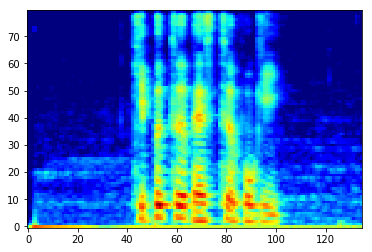

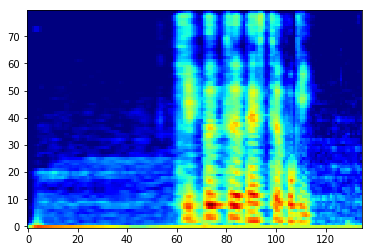

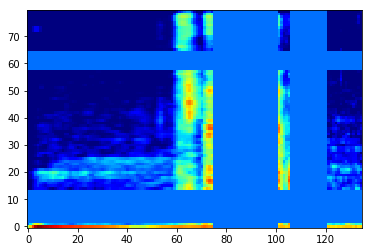

In [65]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='')
    parser.add_argument('-i', '--input', dest='input', type=str, default="data/test.wav", help='input file')
    args = parser.parse_args([])
    main(args)